In [99]:
import os
import tqdm
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt

In [86]:
class CityData:
    def __init__(self, text: list[str]):
        self.region = None
        self.uf = None
        self.station = None
        self.code = None
        self.latitude = None
        self.longitude = None
        self.altitude = None
        self.fundation_date = None

        self.parse_text(text)
        self.time_series = self.parse_time_series(text)

    def sanitize_value(self, value: str):
        return value.split(';')[1].strip()

    def parse_text(self, text: list[str]):
        self.region = self.sanitize_value(text[0])
        self.uf = self.sanitize_value(text[1])
        self.station = self.sanitize_value(text[2])
        self.code = self.sanitize_value(text[3])
        self.latitude = self.sanitize_value(text[4])
        self.longitude = self.sanitize_value(text[5])
        self.altitude = self.sanitize_value(text[6])
        self.fundation_date = self.sanitize_value(text[7])

    def parse_time_series(self, text: list[str]):
        header = [col for col in text[8].split(';') if col != '\n']
        mapping = {col.strip(): [] for col in header}
        for line in text[9:]:
            for idx, item in enumerate(line.split(';')):
                if item != '\n':
                    item = item.strip()
                    item = item.replace(',','.')
                    if idx >= 2 and ',' :
                        if item != "":
                            item = float(item)
                        else:
                            item = None
                    mapping[header[idx]].append(item)

        
        return pd.DataFrame(mapping)


    def get_temperature_series(self):
        self.temperature_series = self.time_series['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].copy()
        self.temperature_series.fillna(self.temperature_series.mean(), inplace=True)

In [137]:
PATH = './../clima/data'

data: list[CityData] = []
files = [file for file in os.listdir(os.path.normpath(PATH)) if '_SP_A' in file]
for file in files:
    print(file)
    with open(os.path.normpath(os.path.join(PATH, file)), 'r', encoding='latin1') as f:
        data.append(CityData(f.readlines()))

INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A705_BAURU_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A706_CAMPOS DO JORDAO_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A707_PRESIDENTE PRUDENTE_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A708_FRANCA_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A711_SAO CARLOS_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A712_IGUAPE_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A713_SOROCABA_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A714_ITAPEVA_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A715_SAO MIGUEL ARCANJO_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A716_OURINHOS_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A718_RANCHARIA_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A725_AVARE_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A726_PIRACICABA_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A727_LINS_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A728_TAUBATE_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A733_JALES_01-01-2023_A_31-10-2023.CSV
INMET_SE_SP_A734_VALPARAISO_01-01-2023_A_31-10-2023.CSV


Para simplificar, vamos trabalhar apenas com uma série temporal de cada cidade. Tomaremos a temperatura máxima na hora anterior.


In [88]:
def get_all_temperature_series(data):
    for city in data:
        city.get_temperature_series()

get_all_temperature_series(data)

In [116]:
graph = nx.Graph()

graph.add_nodes_from((city.station, city.uf) for city in data)

In [117]:
for city1 in tqdm.tqdm(data):
    for city2 in data:
        if city1.station == city2.station and city1.uf == city2.uf:
            continue

        correlation = np.corrcoef(city1.temperature_series, city2.temperature_series)
        graph.add_edge((city1.station, city1.uf), (city2.station, city2.uf), weight=correlation[0][1])

100%|██████████| 566/566 [00:56<00:00,  9.97it/s]


In [118]:
n_nodes = len(graph.nodes())
n_edges = (n_nodes * (n_nodes - 1) )/ 2

print(len(graph.edges()), n_edges)

159895 159895.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

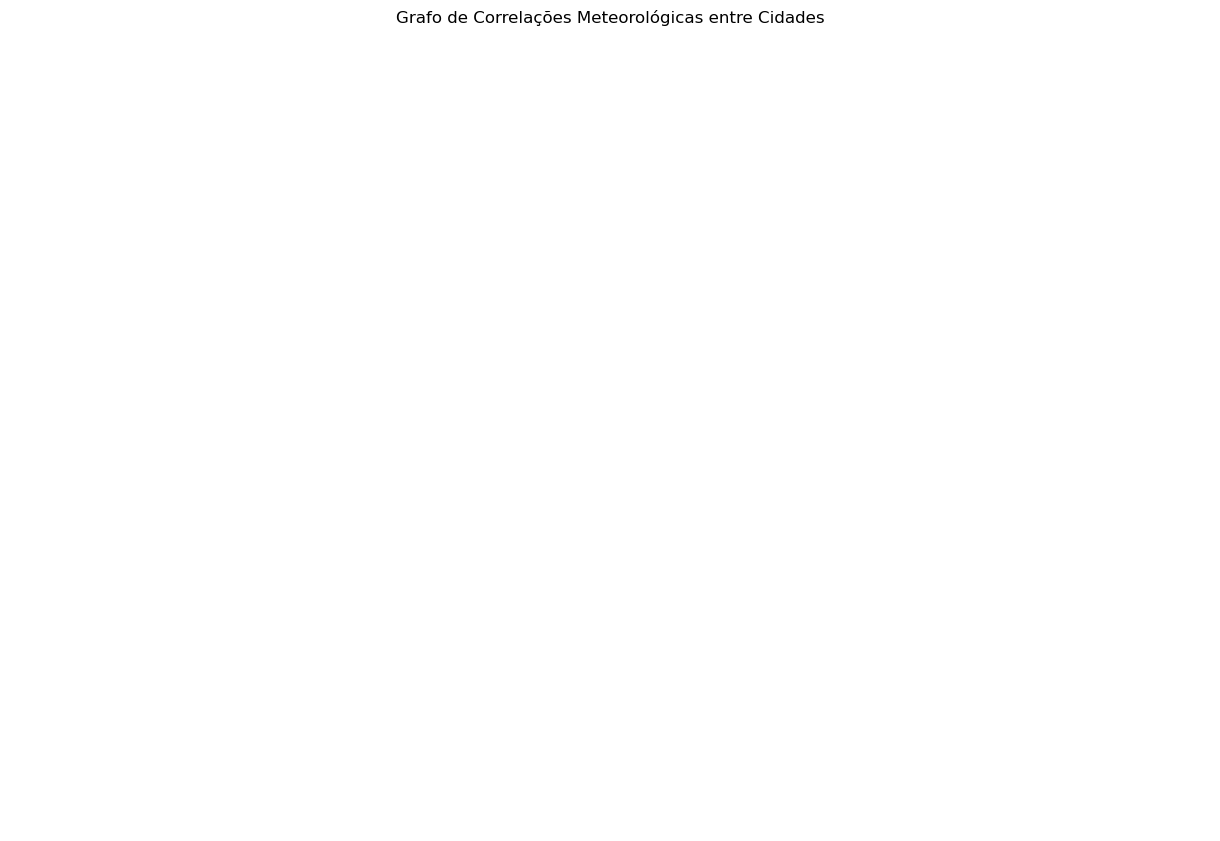

In [119]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph)
weights = [graph.get_edge_data(u,v)['weight'] for u,v in graph.edges()]
weights = [weight**4 for weight in weights]
edge_labels = {(u, v): f'{w:.2f}' for u, v, w in graph.edges(data='weight')}
nx.draw(graph, pos, with_labels=True, node_color='lightblue', width=weights, edge_color='gray')
# nx.draw_networkx_edge_labels(graph,pos,edge_labels=edge_labels)
plt.title("Grafo de Correlações Meteorológicas entre Cidades")
plt.show()

In [124]:
df_list = [(city.station, city.uf, float(city.latitude.replace(',', '.')), float(city.longitude.replace(',', '.'))) for city in data]
df = pd.DataFrame(df_list, columns=['city', 'uf', 'latitude', 'longitude'])

In [121]:
import plotly.express as px
import plotly.graph_objects as go

In [128]:
df

,city,uf,latitude,longitude
0,BRASILIA,DF,-15.789444,-47.925833
1,BRAZLANDIA,DF,-15.599722,-48.131111
2,AGUAS EMENDADAS,DF,-15.596491,-47.625801
3,GAMA (PONTE ALTA),DF,-15.935278,-48.137500
4,PARANOA (COOPA-DF),DF,-16.012222,-47.557417
...,...,...,...,...
561,ARARANGUA,SC,-28.931353,-49.497920
562,ITAJAI,SC,-26.950833,-48.761944
563,RANCHO QUEIMADO,SC,-27.678611,-49.041944
564,CHAPECO,SC,-27.085311,-52.635711


In [129]:
df.loc[(df['city'] == 'BRASILIA') & (df['uf'] == 'DF'), ['latitude', 'longitude']].values[0]

array([-15.78944444, -47.92583332])

In [134]:
df

,city,uf,latitude,longitude
0,BRASILIA,DF,-15.789444,-47.925833
1,BRAZLANDIA,DF,-15.599722,-48.131111
2,AGUAS EMENDADAS,DF,-15.596491,-47.625801
3,GAMA (PONTE ALTA),DF,-15.935278,-48.137500
4,PARANOA (COOPA-DF),DF,-16.012222,-47.557417
...,...,...,...,...
561,ARARANGUA,SC,-28.931353,-49.497920
562,ITAJAI,SC,-26.950833,-48.761944
563,RANCHO QUEIMADO,SC,-27.678611,-49.041944
564,CHAPECO,SC,-27.085311,-52.635711


In [136]:
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", zoom=3, mapbox_style='open-street-map')

for a, b, features in graph.edges(data=True):
    city_a, uf_a = a
    city_b, uf_b = b
    if features['weight'] >= 0.92:
        latitude_a, longitude_a = df.loc[(df['city'] == city_a) & (df['uf'] == uf_a), ['latitude', 'longitude']].values[0]
        latitude_b, longitude_b = df.loc[(df['city'] == city_b) & (df['uf'] == uf_b), ['latitude', 'longitude']].values[0]
        fig.add_trace(go.Scattermapbox(mode='lines', lon=[longitude_a, longitude_b], lat=[latitude_a, latitude_b], line_color='steelblue'))

fig.show()